### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

### Functions

In [ ]:
def inspect_data(data, periods, categories, cols):
  figs, axs = plt.subplots(len(cols), 1, figsize=(17,17))
  for i, col in enumerate(cols):
        axs[i].plot(data[col])
        axs[i].set_title("Number " +str(col)+ ", Category " +str(categories[col]))
        axs[i].set_xlim(periods[col])
  plt.show()

In [ ]:
def build_sequences(data, lenghts, window=200, stride=20, telescope=9):
  assert window % stride == 0

  dataset = []
  labels = []
  for i in np.arange(data.shape[0]):
    check = lenghts[i][0] % window - telescope
    size = (window - check) % window
    if size > 0 and data.shape[1] - lenghts[i][0] - size < 0:
      padding = np.zeros(size - (data.shape[1] - lenghts[i][0]), dtype='float32')
      temp_data = np.concatenate((padding, data[i]))
    else:
      temp_data = data[i].copy()

    for idx in np.arange(temp_data.shape[0]-lenghts[i][0]-size, temp_data.shape[0]-window-telescope, stride):
      dataset.append(temp_data[idx:idx+window])
      labels.append(temp_data[idx+window:idx+window+telescope])

  dataset = np.array(dataset)
  labels = np.array(labels)

  return dataset, labels

In [ ]:
def plot_results(history):
  best_epoch = np.argmin(history['val_loss'])
  plt.figure(figsize=(17,4))
  plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
  plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.title('Mean Squared Error')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  plt.figure(figsize=(18,3))
  plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

### Load and process data

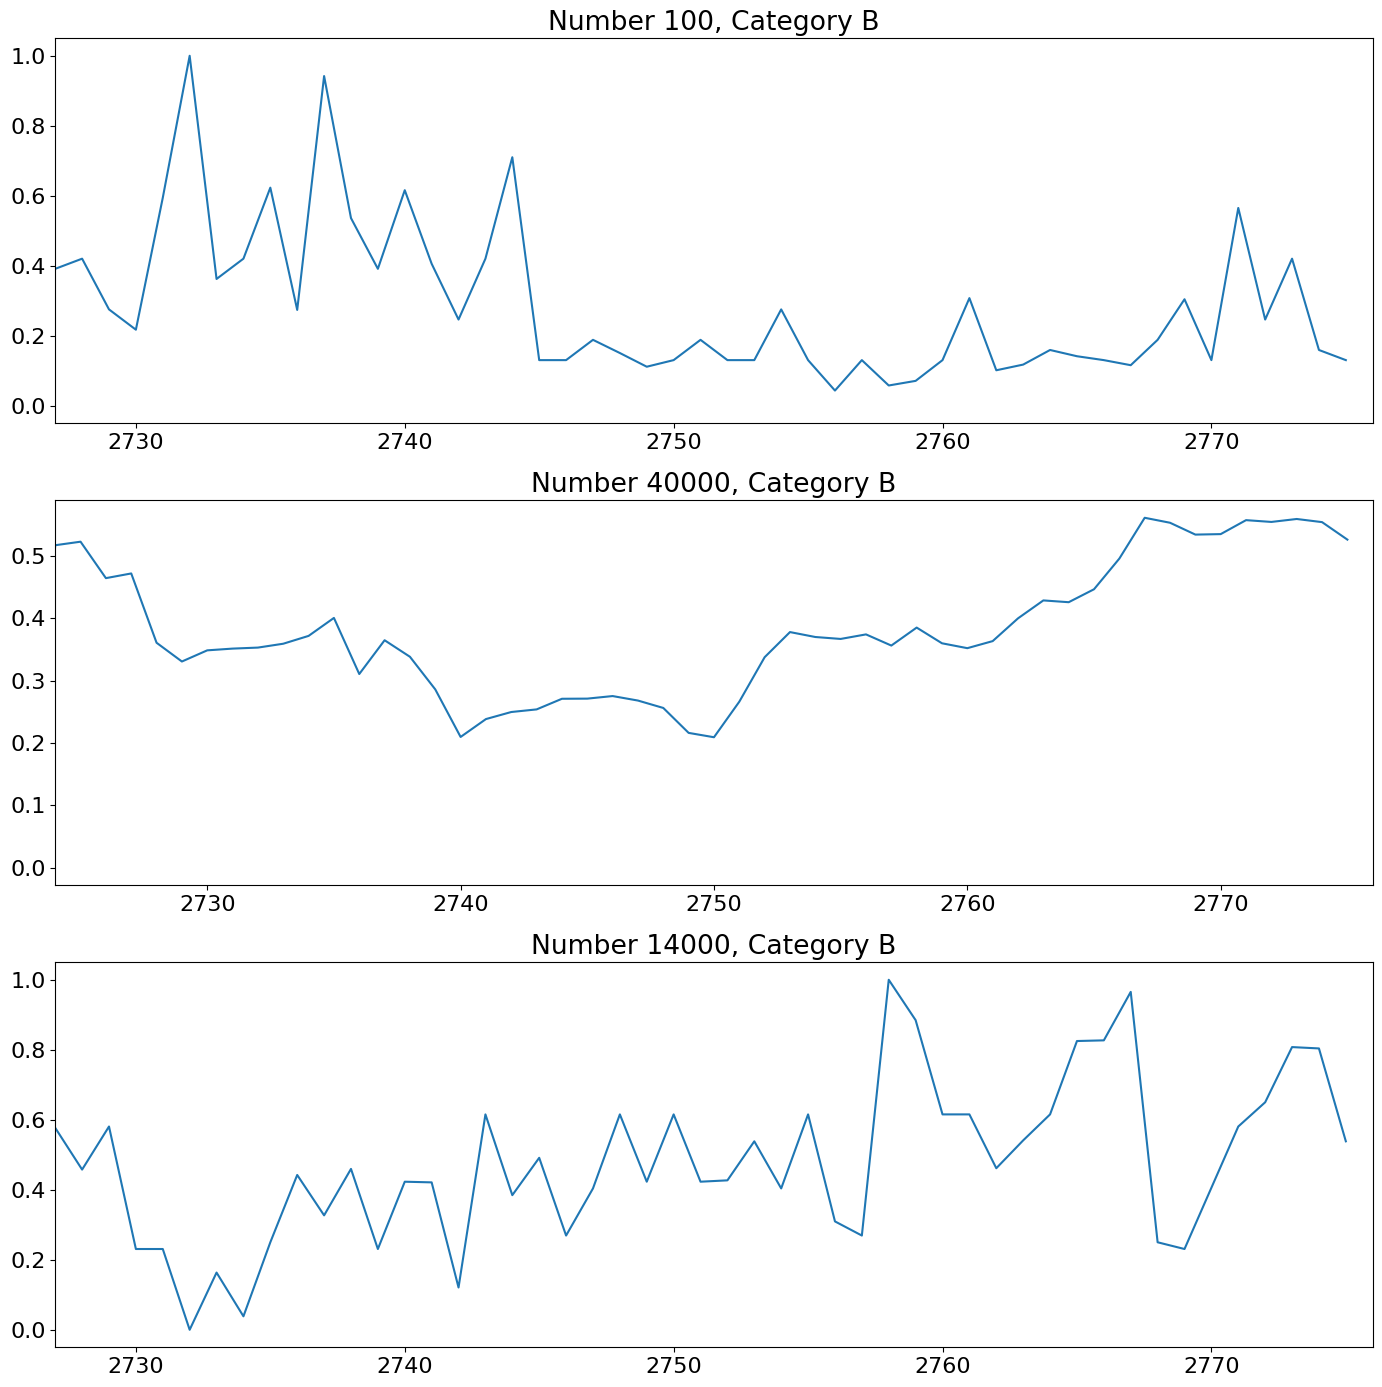

In [ ]:
# Load data
data_train = np.load('training_dataset/split_dataset/data_train.npy', allow_pickle=True)
periods_train = np.load('training_dataset/split_dataset/periods_train.npy', allow_pickle=True)
categories_train = np.load('training_dataset/split_dataset/category_train.npy', allow_pickle=True)
data_val = np.load('training_dataset/split_dataset/data_val.npy', allow_pickle=True)
periods_val = np.load('training_dataset/split_dataset/periods_val.npy', allow_pickle=True)
categories_val = np.load('training_dataset/split_dataset/category_val.npy', allow_pickle=True)

inspect_data(data_train, periods_train, categories_train, [100, 40000, 14000])

In [ ]:
# Set variables used for training
epochs        = 200
window        = 200
telescope     = 18

early_stopping = tfk.callbacks.EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  patience=12,
                  restore_best_weights=True)

lr_scheduling = tfk.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  mode='min',
                  patience=7,
                  factor=0.99,
                  min_lr=1e-5)

callbacks = [early_stopping, lr_scheduling]

### ResNet like Model v1

In [ ]:
# Set variables
batch_size    = 128
stride        = 20

# Prepare training and validation set
X_train, y_train = build_sequences(
    data = data_train,
    lenghts = np.diff(periods_train),
    window = window,
    stride = stride,
    telescope = telescope
)

X_val, y_val = build_sequences(
    data = data_val,
    lenghts = np.diff(periods_val),
    window = window,
    stride = stride,
    telescope = telescope
)

input_shape   = (X_train.shape[1],1)
output_shape  = (y_train.shape[1],1)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_train: {y_val.shape}")
print(f"Input shape: {input_shape}, output shape: {output_shape}")

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add Bidirectional LSTM layers with 128 units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add 1D Convolution layers with 256 filters and a kernel size of 1
    filters = 256
    s1 = tfkl.Conv1D(
        filters=filters,
        kernel_size=1,
        padding='same',
        activation='relu',
        name='conv1'
        )(x)

    s2 = tfkl.Conv1D(
        filters=filters,
        kernel_size=1,
        padding='same',
        activation='relu',
        name='conv2'
        )(s1)

    s3 = tfkl.Add(name='add')([x,s2])

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 1, padding='same', name='output_layer')(s3)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    output_layer = output_layer[:,:,0]

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data =(X_val, y_val),
    callbacks = callbacks
).history

# Save the model
model.save('Models/ResNet_v1')

In [ ]:
# Plot results
plot_results(history)

### ResNet like Model v2

In [ ]:
# Set variables
batch_size    = 128
stride        = 20

# Prepare training and validation set
X_train, y_train = build_sequences(
    data = data_train,
    lenghts = np.diff(periods_train),
    window = window,
    stride = stride,
    telescope = telescope
)

X_val, y_val = build_sequences(
    data = data_val,
    lenghts = np.diff(periods_val),
    window = window,
    stride = stride,
    telescope = telescope
)

input_shape   = (X_train.shape[1],1)
output_shape  = (y_train.shape[1],1)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_train: {y_val.shape}")
print(f"Input shape: {input_shape}, output shape: {output_shape}")

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add Bidirectional LSTM layers with 128 units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    # Add 1D Convolution layers with 256 filters and a kernel size of 1
    filters = 256
    s1 = tfkl.Conv1D(
        filters=filters,
        kernel_size=1,
        padding='same',
        activation='relu',
        name='conv1'
        )(x)

    s2 = tfkl.Conv1D(
        filters=filters,
        kernel_size=1,
        padding='same',
        activation='relu',
        name='conv2'
        )(s1)

    s3 = tfkl.Add(name='add')([x,s2])
    s4 = tfkl.ReLU(name='relu')(s3)
    s5 = tfkl.MaxPooling1D(name='pooling')(s4)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 1, padding='same', name='output_layer')(s5)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    output_layer = output_layer[:,:,0]

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data =(X_val, y_val),
    callbacks = callbacks
).history

# Save the model
model.save('Models/ResNet_v2')

In [ ]:
# Plot results
plot_results(history)

### ResNet like Model v3

In [ ]:
# Set variables
batch_size    = 128
stride        = 25

# Prepare training and validation set
X_train, y_train = build_sequences(
    data = data_train,
    lenghts = np.diff(periods_train),
    window = window,
    stride = stride,
    telescope = telescope
)

X_val, y_val = build_sequences(
    data = data_val,
    lenghts = np.diff(periods_val),
    window = window,
    stride = stride,
    telescope = telescope
)

input_shape   = (X_train.shape[1],1)
output_shape  = (y_train.shape[1],1)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_train: {y_val.shape}")
print(f"Input shape: {input_shape}, output shape: {output_shape}")

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x1 = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm1_1')(input_layer)
    x1 = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm1_2')(x1)

        # Add a Bidirectional LSTM layer with 64 units
    x2 = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm2_1')(input_layer)
    x2 = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm2_2')(x2)

      # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    filters = 256
    name = 'nome'
    s1_1 = tfkl.Conv1D(
    filters=filters,
    kernel_size=1,
    padding='same',
    name='Conv1-Resnet1'
    )(x1)

    s1_1 = tfkl.BatchNormalization()(s1_1)
    s1_1 = tfkl.Activation('relu')(s1_1)

    s1_2 = tfkl.Conv1D(
    filters=filters,
    kernel_size=1,
    padding='same',
    name='Conv2-Resnet21'
    )(s1_1)

    s1_2 = tfkl.BatchNormalization()(s1_2)
    s1_2 = tfkl.Activation('relu')(s1_2)
    s1_2 = tfkl.MaxPooling1D(name='pooling1')(s1_2)


    s2_1 = tfkl.MaxPooling1D(name='pooling2')(x2)


    s3 = tfkl.Add(name='add-final')([s1_2,s2_1])
    s4 = tfkl.BatchNormalization()(s3)
    s5 = tfkl.ReLU(name='relu-final')(s4)
    s6 = tfkl.MaxPooling1D(name='pooling-final')(s5)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 1, padding='same', name='output_layer')(s6)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    output_layer = output_layer[:,:,0]

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data =(X_val, y_val),
    callbacks = callbacks
).history

# Save the model
model.save('Models/ResNet_v3')

In [ ]:
# Plot results
plot_results(history)

### ResnNet like Model v4

In [ ]:
# Set variables
batch_size    = 256
dropout_rate  = 2/10
stride        = 40

# Prepare training and validation set
X_train, y_train = build_sequences(
    data = data_train,
    lenghts = np.diff(periods_train),
    window = window,
    stride = stride,
    telescope = telescope
)

X_val, y_val = build_sequences(
    data = data_val,
    lenghts = np.diff(periods_val),
    window = window,
    stride = stride,
    telescope = telescope
)

input_shape   = (X_train.shape[1],1)
output_shape  = (y_train.shape[1],1)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_train: {y_val.shape}")
print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (123207, 200), y_train: (123207, 18)
X_val: (14000, 200), y_train: (14000, 18)
Input shape: (200, 1), output shape: (18, 1)


In [ ]:
def build_model(input_shape, output_shape, dropout_rate):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add Bidirectional LSTM layers with 128 units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    # Add a 1D Convolution layer with 256 filters and a kernel size of 3
    filters = 256
    s1 = tfkl.Conv1D(
        filters=filters,
        kernel_size=3,
        padding='same',
        activation='relu',
        name='conv1'
        )(x)

    # Add dropout
    s1 = tfkl.Dropout(dropout_rate, seed=seed)(s1)

    # Add a 1D Convolution layer with 256 filters and a kernel size of 3
    s2 = tfkl.Conv1D(
        filters=filters,
        kernel_size=3,
        padding='same',
        activation='relu',
        name='conv2'
        )(s1)

    # Add dropout
    s2 = tfkl.Dropout(dropout_rate, seed=seed)(s2)

    s3 = tfkl.Add(name='add')([x,s2])
    s4 = tfkl.ReLU(name='relu')(s3)
    s5 = tfkl.MaxPooling1D(name='pooling')(s4)

    # Add Bidirectional LSTM layers with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm_3')(s5)
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm_4')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 1
    filters = 128
    s1 = tfkl.Conv1D(
        filters=filters,
        kernel_size=1,
        padding='same',
        activation='relu',
        name='conv3'
        )(x)

    # Add dropout
    s1 = tfkl.Dropout(dropout_rate, seed=seed)(s1)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 1
    s2 = tfkl.Conv1D(
        filters=filters,
        kernel_size=1,
        padding='same',
        activation='relu',
        name='conv4'
        )(s1)

    # Add dropout
    s2 = tfkl.Dropout(dropout_rate, seed=seed)(s2)

    s3 = tfkl.Add(name='add2')([x,s2])
    s4 = tfkl.ReLU(name='relu2')(s3)
    s5 = tfkl.MaxPooling1D(name='pooling2')(s4)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 1, padding='same', name='output_layer')(s5)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    output_layer = output_layer[:,:,0]

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 bidirectional_lstm_2 (Bidi  (None, 200, 256)             394240    ['bidirectional_lstm[0][0]']  
 rectional)                                                                                       
                                                                                              

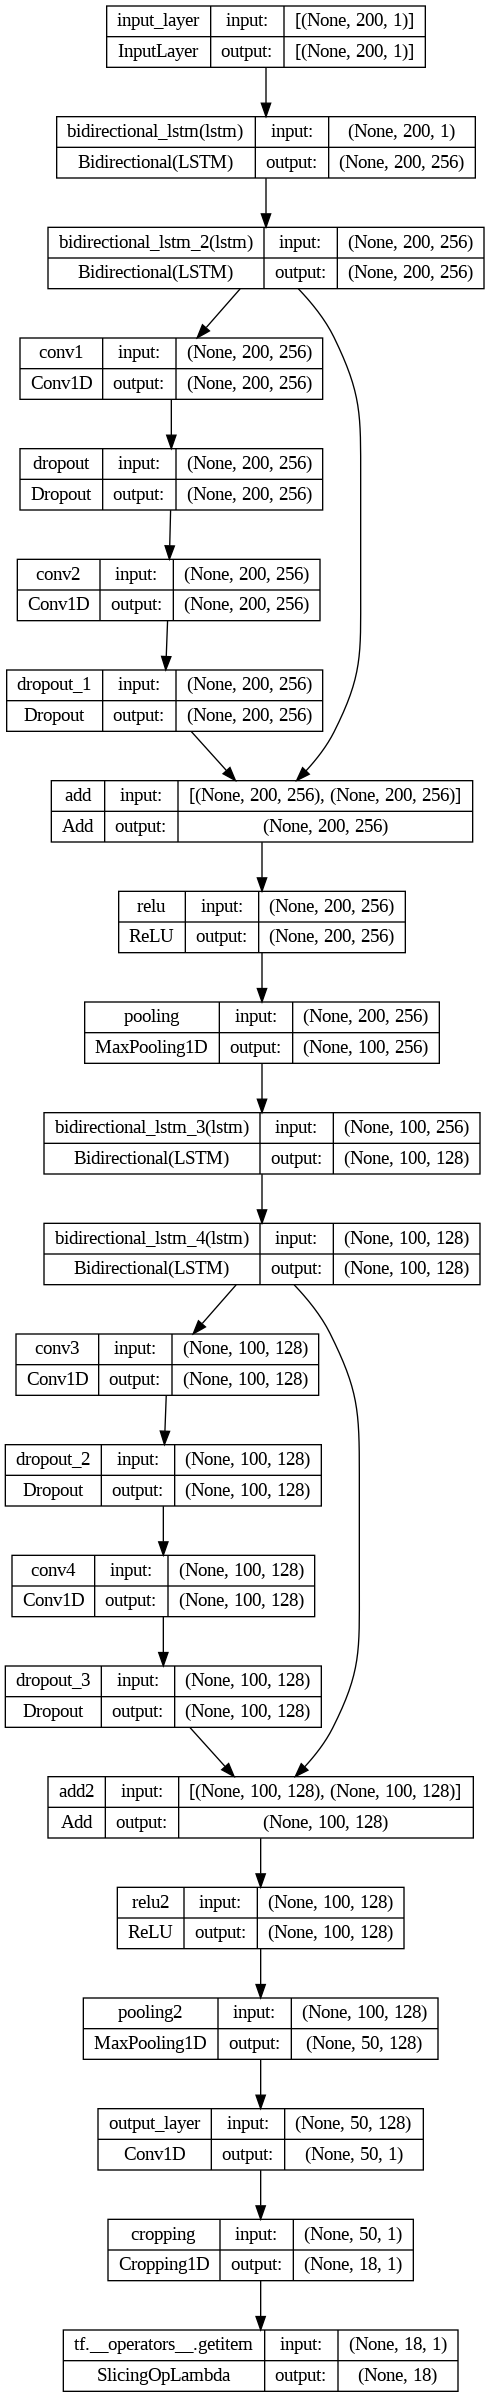

In [ ]:
model = build_model(input_shape, output_shape, dropout_rate)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data =(X_val, y_val),
    callbacks = callbacks
).history

# Save the model
model.save('Models/ResNet_v4')

Epoch 1/200
482/482 [==============================] - 104s 177ms/step - loss: 0.0517 - val_loss: 0.0418 - lr: 0.0010
Epoch 2/200
482/482 [==============================] - 83s 172ms/step - loss: 0.0155 - val_loss: 0.0153 - lr: 0.0010
Epoch 3/200
482/482 [==============================] - 83s 172ms/step - loss: 0.0129 - val_loss: 0.0168 - lr: 0.0010
Epoch 4/200
482/482 [==============================] - 83s 172ms/step - loss: 0.0131 - val_loss: 0.0119 - lr: 0.0010
Epoch 5/200
482/482 [==============================] - 83s 172ms/step - loss: 0.0125 - val_loss: 0.0117 - lr: 0.0010
Epoch 6/200
482/482 [==============================] - 84s 174ms/step - loss: 0.0123 - val_loss: 0.0122 - lr: 0.0010
Epoch 7/200
482/482 [==============================] - 83s 173ms/step - loss: 0.0121 - val_loss: 0.0114 - lr: 0.0010
Epoch 8/200
482/482 [==============================] - 84s 173ms/step - loss: 0.0119 - val_loss: 0.0113 - lr: 0.0010
Epoch 9/200
482/482 [==============================] - 83s 173m

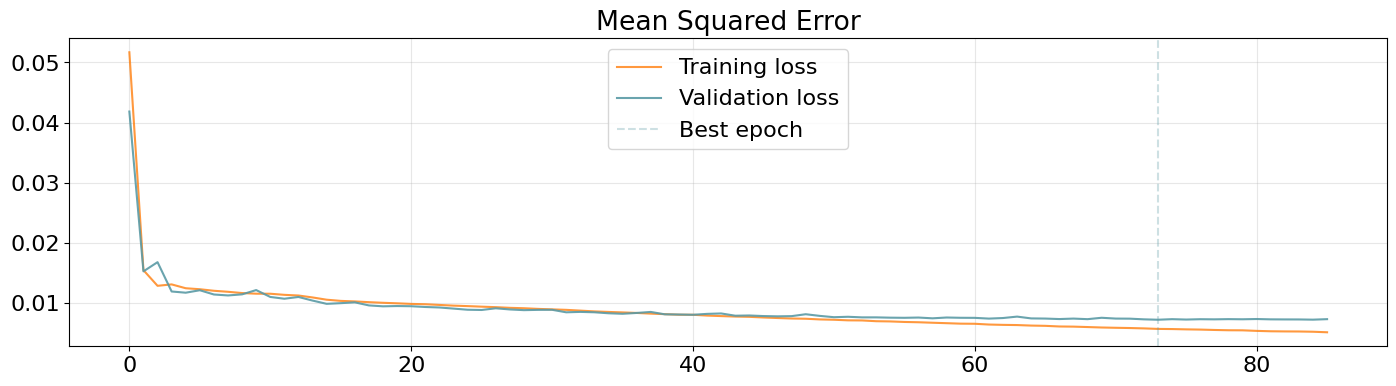

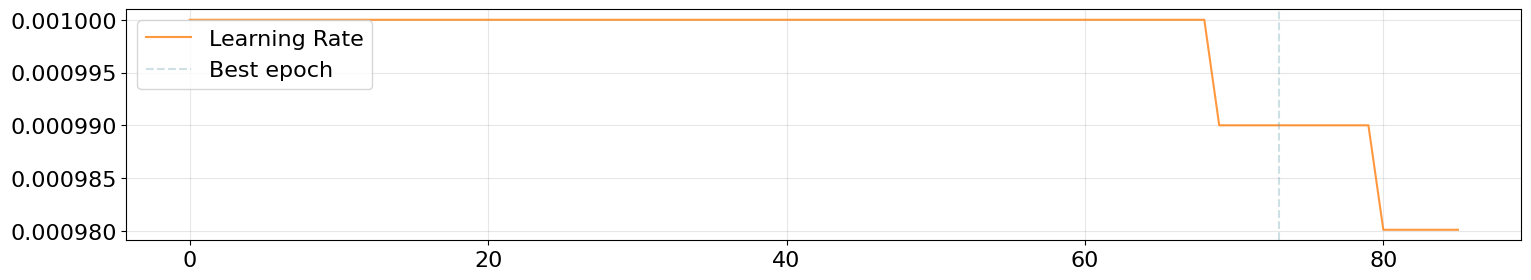

In [ ]:
# Plot results
plot_results(history)